The task is to build a continuous bag of words model using Tensorflow.

In [1]:
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model

In [2]:
# using the Gensim corpus 
dataset = api.load('text8')

In [3]:
doc_lengths = []
for x in dataset:
    l = len(x)
    doc_lengths.append(l)

In [4]:
# estimating the texts length
np.mean(doc_lengths), np.std(doc_lengths)

(9997.182245737802, 116.17898450079628)

In [5]:
# convert texts to sequences
vocab_size = 20000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

In [6]:
# build a model
context_size = 10
embedding_dim = 50

i = Input(shape=(context_size,))
x = Embedding(vocab_size, embedding_dim)(i)
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dense(vocab_size, use_bias=False)(x)

model = Model(i, x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            1000000   
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20000)             1000000   
                                                                 
Total params: 2,000,000
Trainable params: 2,000,000
Non-trainable params: 0
_________________________________________________________________


In [8]:
# use data generator to pass data in batches while fitting
half_context_size = context_size // 2

def data_generator(sequences, batch_size=128):
    X_batch = np.zeros((batch_size, context_size))
    Y_batch = np.zeros(batch_size)
    n_batches = int(np.ceil(len(sequences)) / batch_size)
    while True:
        random.shuffle(sequences)
        
        for i in range(n_batches):
            batch_sequences = sequences[i * batch_size:(i+1) * batch_size]
            current_batch_size = len(batch_sequences)
            
            for ii in range(current_batch_size):
                seq = batch_sequences[ii]
                j = np.random.randint(0, len(seq) - context_size - 1)
                x1 = seq[j:j + half_context_size]
                x2 = seq[j + half_context_size + 1:j + context_size + 1]
                X_batch[ii, :half_context_size] = x1
                X_batch[ii, half_context_size:] = x2
                y = seq[j + half_context_size]
                Y_batch[ii] = y
            
            yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [9]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', metrics=['accuracy'])

In [10]:
batch_size = 128
r = model.fit(data_generator(sequences, batch_size),
              epochs=10000,
              steps_per_epoch=int(np.ceil(len(sequences)) / batch_size), verbose=0)

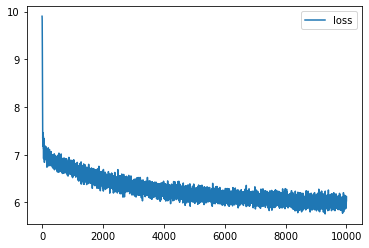

In [21]:
# loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.legend()

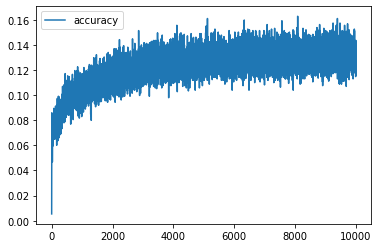

In [22]:
# accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

In [23]:
embeddings = model.layers[1].get_weights()[0]

In [24]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [25]:
# find semantic neighbors
def print_neighbors(query):
    query_idx = tokenizer.word_index[query]
    query = embeddings[query_idx:query_idx+1]
    distances, indices = neighbors.kneighbors(query)
    for idx in indices[0][1:]:
        word = tokenizer.index_word[idx]
        print(word)

In [26]:
print_neighbors('queen')

elizabeth
king
princess
regent
prince


In [27]:
print_neighbors('berlin')

munich
bonn
frankfurt
hamburg
stockholm


In [28]:
print_neighbors('scientist')

psychologist
anthropologist
architect
astronomer
physician


In [29]:
print_neighbors('beer')

cheese
soup
fermented
ale
chocolate


In [30]:
# find analogies
def get_embedding(word):
    idx = tokenizer.word_index[word]
    return embeddings[idx:idx+1]

king = get_embedding('king')
man = get_embedding('man')
woman = get_embedding('woman')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

king
queen
henry
prince
elizabeth
vi
